In [1]:
import numpy as np

In [2]:
from code5_3 import *  # Gauss-Newton法のコードを読み込み
from code5_4 import *  # Huschens法のコードを読み込み

In [3]:
# 非線形最小二乗フィッティングのデータ生成と解法適用（Gauss–Newton / Huschens）である。
# モデル： f(t; x) = x1 * exp(x2 * t) + x3 * exp(x4 * t)
# 目的： 観測 b に対して r(x) = b - f(t; x) の二乗和最小化問題を解く。

import numpy as np

# -----------------------------
# 1) 合成データ生成
# -----------------------------
t = np.linspace(0.0, 10.0, 20)  # 観測点（時間）の等間隔グリッド
true_x = np.array([2.0, -0.5, 1.0, -0.1])  # 真のパラメータ（x1, x2, x3, x4）


def func(x: np.ndarray) -> np.ndarray:
    """
    モデル f(t; x) を返す関数である。
    x = (x1, x2, x3, x4)
    """
    return x[0] * np.exp(x[1] * t) + x[2] * np.exp(x[3] * t)


# --- ヤコビアン（モデル f の ∂f/∂x） ---
def jac(x: np.ndarray) -> np.ndarray:
    """
    残差 r(x) = b - f(t; x) のヤコビアン J_r(x) を返すである。
    注意： r = b - f なので J_r = - J_f となる（符号に注意）である。
    形状は (len(t), 4)。
    """
    x1, x2, x3, x4 = x
    J = np.zeros((t.size, len(x)))
    # ∂f/∂x1 = exp(x2 * t)
    J[:, 0] = np.exp(x2 * t)
    # ∂f/∂x2 = x1 * t * exp(x2 * t)
    J[:, 1] = x1 * t * np.exp(x2 * t)
    # ∂f/∂x3 = exp(x4 * t)
    J[:, 2] = np.exp(x4 * t)
    # ∂f/∂x4 = x3 * t * exp(x4 * t)
    J[:, 3] = x3 * t * np.exp(x4 * t)
    return -J  # r = b - f のためマイナスを付ける（J_r = -J_f）


# --- 観測データ b を生成（真値 + ノイズ） ---
np.random.seed(0)  # 再現性確保
b = func(true_x) + np.random.normal(0.0, 0.2, len(t))  # 平均0, 標準偏差0.2のガウス雑音


# --- 残差関数 r(x) = b - f(t; x) ---
def r_func(x: np.ndarray) -> np.ndarray:
    return b - func(x)


# -----------------------------
# 2) 解法の適用
# -----------------------------
# 初期推定：真値の 90% から開始（非線形最適化では初期値が重要）
x_0 = 0.9 * true_x

# Gauss–Newton 法で最小二乗問題を解く
GN_x = gauss_newton(r_func, jac, x_0)

# Huschens 法（Gauss–Newton に低ランク補正を加える改善法）で解く
Hu_x = Huschens(r_func, jac, x_0)

# -----------------------------
# 3) 結果の簡易表示
# -----------------------------
print("\n=== 推定結果 ===")
print("真値        :", true_x)
print("Gauss-Newton:", GN_x)
print("Huschens    :", Hu_x)

# 最終残差ノルムの比較（小さいほど当てはまりが良い）
GN_res = np.linalg.norm(r_func(GN_x))
HU_res = np.linalg.norm(r_func(Hu_x))
print("\n||r(GN_x)|| =", GN_res)
print("||r(Hu_x)|| =", HU_res)

GN, iter: 28 ||r(x_k)||: 0.687458491203688
Huschens, iter: 15 ||r(x_k)||: 0.6874584912028432

=== 推定結果 ===
真値        : [ 2.  -0.5  1.  -0.1]
Gauss-Newton: [ 2.0556254  -0.52750805  1.25092326 -0.11193819]
Huschens    : [ 2.05562346 -0.52750845  1.25092529 -0.11193837]

||r(GN_x)|| = 0.687458491203076
||r(Hu_x)|| = 0.6874584912028432


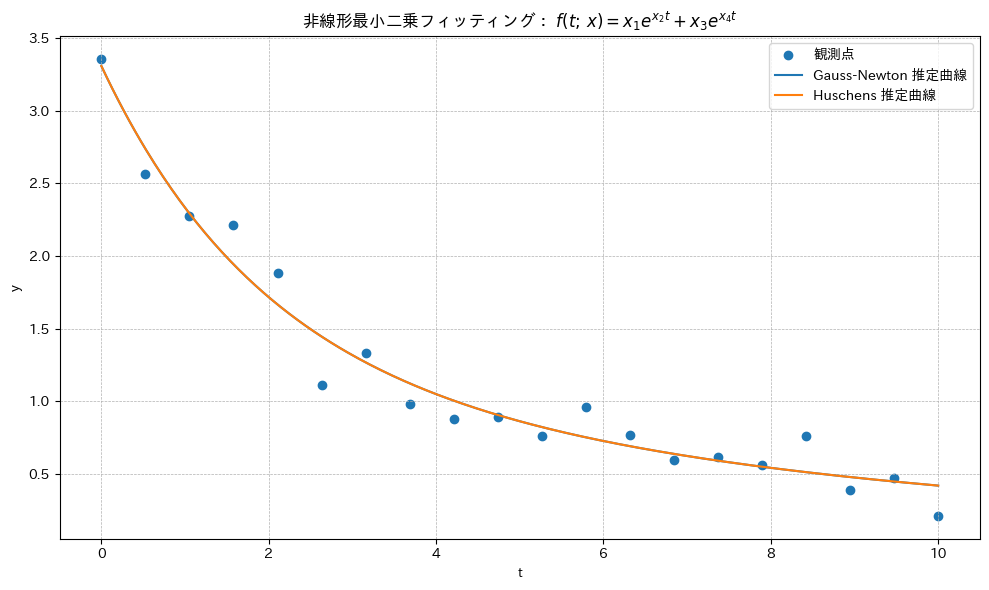

In [4]:
# フィッティング結果のプロットである。
# 前提：t, b, GN_x, Hu_x, func などが既に定義済みであること（直前セル参照）。

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# 可視化用の密な t グリッド
t_fit = np.linspace(0.0, 10.0, 300)

def func_plt(x, t_grid):
    """モデル f(t; x) = x1 * exp(x2 t) + x3 * exp(x4 t) を t_grid 上で評価する。"""
    return x[0] * np.exp(x[1] * t_grid) + x[2] * np.exp(x[3] * t_grid)

# 推定曲線の生成（存在するものだけ描く）
curves = []
labels = []
try:
    est_b_fit_gn = func_plt(GN_x, t_fit)
    curves.append(est_b_fit_gn)
    labels.append('Gauss-Newton 推定曲線')
except NameError:
    pass

try:
    est_b_fit_hu = func_plt(Hu_x, t_fit)
    curves.append(est_b_fit_hu)
    labels.append('Huschens 推定曲線')
except NameError:
    pass

# プロット
plt.figure(figsize=(10, 6))
plt.scatter(t, b, label='観測点')  # 観測データ

# 推定曲線の描画（複数あれば両方描く）
for y_fit, lab in zip(curves, labels):
    plt.plot(t_fit, y_fit, label=lab)

# 数式ラベル
eq_text = r'$f(t;\,x)=x_1 e^{x_2 t}+x_3 e^{x_4 t}$'
plt.xlabel("t")
plt.ylabel("y")
plt.title("非線形最小二乗フィッティング： " + eq_text)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()